---

<br>
<p align="center">
  <!---<img src="https://www.estudiaradistancia.com.ar/logos/original/logo-universidad-de-buenos-aires.webp" height=80 />--->
  <img src="https://confedi.org.ar/wp-content/uploads/2020/09/fiuba_logo.jpg" height="180"/>
</p>
<br>

---

<br>
<p align="center">
<font size="+3">
[75.06] Organizacion de Datos - Curso Rodriguez
<br>
Trabajo Práctico II
<br>
Análisis de propiedades en venta - Dataset Properati
Segundo Cuatrimestre - 2022
</font>
</p>
<br>

---

<br>
<p align="center">
<font size="+3">
GRUPO 3
</font>
<br>
<font size="+2">
INTEGRANTES
</font>
<br>
<font size="+1">
Ramiro Gestoso,  
Facundo Monpelat,
Paula Bruck,
Miguel Vasquez
</font>

</p>

<br>
<br>

---

---

---

## Introducción 

En el presente Trabajo Practico se busca continuar con la aplicación de técnicas presentes en ciencia de datos, en específico:
- Procesamiento del lenguaje natural y su uso para aplicación en modelos.
- Utilización de redes neuronales para modelos de clasificació y regresión.
- Aplicación de ensambles de modelos para la reutilización y refinamiento de modelos previamente entrenados.

Todo ello utilizando el conjunto de datos provisto por la empresa Properati correspondiente a anuncios de propiedades en venta de la República Argentina publicados durante el año 2021 (particularmente se utilizan dos, el mismo empleado en el trabajo práctico anterior y otro adicional que contiene descripciones de las propiedades en venta).

## Índice de contenidos

0. Imports
1. Procesamiento del Lenguaje Natural
    aa) Pasos auxiliares previos a la ampliación
    a) Ampliación del dataset
    b) Modelos (XGB reaplicado)
     - XGBoost con dataset ampliado con hiperparametros del trabajo anterior
     - XGboost con dataset ampliado con nuevos hiperparametros
2. Redes Neuronales
     - Modelo 1: Regresión 
     - Modelo 2: Clasificación
3. Ensamble de modelos
     - Ensamble 1: Ensamble tipo Voting para clasificación
     - Ensamble 2: Ensamble de tipo Stacking para regresión 
4. Conclusiones

## 0. Imports

Sección con imports y definiciones auxiliares iniciales para manipulación general del dataset

In [ ]:
!ls

clasificador_knn.joblib		  out_ecmes.txt
clasificador_randomForest.joblib  properati_argentina_2021_decrip.csv
df_preprocesado.csv		  regresor_knn.joblib
df_target_test.csv		  regresor_xgb.json
df_target_train.csv		  regresor_xgboost.joblib
ds_descripciones.txt		  requirements.txt
ECMes				  stanford-postagger-full-2018-10-16.zip
image-20221108-224047.png	  testFile.txt


Importamos las bibliotecas a utilizar a lo largo de nuestro trabajo 

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.font_manager
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import seaborn as sns

import numpy as np
import scipy.stats as st

import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from sklearn import metrics
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import StackingRegressor

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

import re

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import xgboost
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


## 1. Procesamiento del lenguaje natural

### aa) Pasos auxiliares previos a la ampliación del dataset

Cargamos el dataset de properati con descripciones

In [2]:
ds_descrip = pd.read_csv('properati_argentina_2021_decrip.csv')


En principio se observa la cantidad de observaciones y features contenidas:

In [3]:
shape = ds_descrip.shape
print("Filas: %d Columnas: %d" % (shape[0], shape[1]))

Filas: 460154 Columnas: 2


In [ ]:
ds_descrip.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!<br>APTO ...
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,..."
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...


A efectos de poder utilizar las descripciones vamos a importar el dataset preprocesado del TP1, y el mismo fue modificado de forma que aún contiene las IDs de las propiedades, esto para asi facilitar la combinación de los datos.

In [4]:
ds_preprocesado = pd.read_csv('df_preprocesado.csv')

In [5]:
ds_preprocesado.head()

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once
3,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo
4,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO


Añadimos las descripciones a los datos preprocesados y guardamos el resultado en `ds_pre`:

In [6]:
ds_pre = ds_preprocesado.merge(ds_descrip, on="id", how="left")

In [7]:
ds_pre.shape

(82855, 13)

In [8]:
ds_pre.head()

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,Corredor Responsable: Gustavo Guastello - C.U....
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,Formando parte del Barrio Catalinas Sur: Carac...
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,Luminoso 4 ambientes<br><br>2 dormitorios ampl...
3,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,"EXELENTE PH, CON QUINCHO SEMICUBIERTO Y TERRAZ..."
4,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,"Se trata de un PH de 2 ambientes con patio, po..."


### a) Ampliación del dataset

Comenzamos por convertir a tipo str la columna `property_description`

In [9]:
ds_pre['property_description'] = ds_pre['property_description'].astype(str).str.lower()
ds_pre.head(3)

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,corredor responsable: gustavo guastello - c.u....
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,formando parte del barrio catalinas sur: carac...
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,luminoso 4 ambientes<br><br>2 dormitorios ampl...


Usamos RegexpTokenizer de NLTK para realizar tokenización en combinación con expresiones regulares.

\w+ coincide con los caracteres de palabra Unicode con una o más apariciones; esto incluye la mayoría de los caracteres que pueden formar parte de una palabra en cualquier idioma, así como los números y el guión bajo.

In [10]:
regexp = RegexpTokenizer('\w+')

ds_pre['text_token']=ds_pre['property_description'].apply(regexp.tokenize)
ds_pre.head(3)

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description,text_token
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,corredor responsable: gustavo guastello - c.u....,"[corredor, responsable, gustavo, guastello, c,..."
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,formando parte del barrio catalinas sur: carac...,"[formando, parte, del, barrio, catalinas, sur,..."
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,luminoso 4 ambientes<br><br>2 dormitorios ampl...,"[luminoso, 4, ambientes, br, br, 2, dormitorio..."


Las stopwords son palabras de una lista vacía que se eliminan antes de analizar los datos del lenguaje natural, ya que no contienen información valiosa.

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Make a list of spanish stopwords
stopwords = nltk.corpus.stopwords.words("spanish")

# Extend the list with your own custom stopwords
my_stopwords = ['https', '<br>']
stopwords.extend(my_stopwords)

In [13]:
# Remove stopwords
ds_pre['text_token'] = ds_pre['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
ds_pre.head(3)

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description,text_token
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,corredor responsable: gustavo guastello - c.u....,"[corredor, responsable, gustavo, guastello, c,..."
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,formando parte del barrio catalinas sur: carac...,"[formando, parte, barrio, catalinas, sur, cara..."
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,luminoso 4 ambientes<br><br>2 dormitorios ampl...,"[luminoso, 4, ambientes, br, br, 2, dormitorio..."


Para eliminar palabras poco frecuentes , Primero cambiamos el formato de text_token a cadenas y mantenemos solo las palabras que tienen más de 2 letras

In [14]:
ds_pre['text_string'] = ds_pre['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))


In [15]:
ds_pre[['property_description', 'text_token', 'text_string']].head()


,property_description,text_token,text_string
0,corredor responsable: gustavo guastello - c.u....,"[corredor, responsable, gustavo, guastello, c,...",corredor responsable gustavo guastello 869cont...
1,formando parte del barrio catalinas sur: carac...,"[formando, parte, barrio, catalinas, sur, cara...",formando parte barrio catalinas sur caracteriz...
2,luminoso 4 ambientes<br><br>2 dormitorios ampl...,"[luminoso, 4, ambientes, br, br, 2, dormitorio...",luminoso ambientes dormitorios amplios cocina ...
3,"exelente ph, con quincho semicubierto y terraz...","[exelente, ph, quincho, semicubierto, terraza,...",exelente quincho semicubierto terraza unidad e...
4,"se trata de un ph de 2 ambientes con patio, po...","[trata, ph, 2, ambientes, patio, pasillo, cont...",trata ambientes patio pasillo contrafrente bue...


Creamos una lista de todas las palabras

In [16]:
all_words = ' '.join([word for word in ds_pre['text_string']])


Tokenizamos la lista de todas las palabras.

In [17]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

Creamos una distribución de frecuencias que registre el número de veces que se ha producido cada palabra

In [19]:
fdist = FreqDist(tokenized_words)
fdist

FreqDist({'cocina': 99592, 'ambientes': 82119, 'baño': 80186, 'piso': 74304, 'comedor': 71952, 'propiedad': 70583, 'living': 69640, 'balcón': 65669, 'departamento': 63166, 'edificio': 61573, ...})

Ahora podemos usar nuestro diccionario fdist para descartar palabras que ocurren menos de una cierta cantidad de veces 

In [20]:
ds_pre['text_string_fdist'] = ds_pre['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 6 ]))


In [21]:
ds_pre[['property_description', 'text_token', 'text_string', 'text_string_fdist']].head()


,property_description,text_token,text_string,text_string_fdist
0,corredor responsable: gustavo guastello - c.u....,"[corredor, responsable, gustavo, guastello, c,...",corredor responsable gustavo guastello 869cont...,corredor responsable gustavo guastello 869cont...
1,formando parte del barrio catalinas sur: carac...,"[formando, parte, barrio, catalinas, sur, cara...",formando parte barrio catalinas sur caracteriz...,formando parte barrio catalinas sur caracteriz...
2,luminoso 4 ambientes<br><br>2 dormitorios ampl...,"[luminoso, 4, ambientes, br, br, 2, dormitorio...",luminoso ambientes dormitorios amplios cocina ...,luminoso ambientes dormitorios amplios cocina ...
3,"exelente ph, con quincho semicubierto y terraz...","[exelente, ph, quincho, semicubierto, terraza,...",exelente quincho semicubierto terraza unidad e...,exelente quincho semicubierto terraza unidad e...
4,"se trata de un ph de 2 ambientes con patio, po...","[trata, ph, 2, ambientes, patio, pasillo, cont...",trata ambientes patio pasillo contrafrente bue...,trata ambientes patio pasillo contrafrente bue...


In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Ahora procedemos a la Lematizacion

In [23]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

ds_pre['text_string_lem'] = ds_pre['text_string_fdist'].apply(wordnet_lem.lemmatize)

En algunos conjuntos de datos, no hay palabras para lematizar. Esto lo podemos comprobar de la siguiente manera.

In [24]:
# check if the columns are equal
ds_pre['is_equal']= (ds_pre['text_string_fdist']==ds_pre['text_string_lem'])

In [25]:
# show level count
ds_pre.is_equal.value_counts()

True    82855
Name: is_equal, dtype: int64

In [26]:
ds_pre.shape

(82855, 18)

In [27]:
#!pip install worldcloud #a ver si con el requirements ya agarra

In [28]:
all_words_lem = ' '.join([word for word in ds_pre['text_string_lem']])

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)

Ahora podemos ver las palabras mas comunes

In [31]:
fd.most_common(20)

[('cocina', 99592),
 ('ambientes', 82119),
 ('baño', 80186),
 ('piso', 74304),
 ('comedor', 71952),
 ('propiedad', 70583),
 ('living', 69640),
 ('balcón', 65669),
 ('departamento', 63166),
 ('edificio', 61573),
 ('completo', 54266),
 ('dormitorio', 52740),
 ('pisos', 52114),
 ('expensas', 50048),
 ('frente', 50005),
 ('valor', 48318),
 ('corredor', 47980),
 ('inmueble', 46741),
 ('excelente', 46268),
 ('medidas', 45604)]

In [32]:
fd.tabulate(20)

      cocina    ambientes         baño         piso      comedor    propiedad       living       balcón departamento     edificio     completo   dormitorio        pisos     expensas       frente        valor     corredor     inmueble    excelente      medidas 
       99592        82119        80186        74304        71952        70583        69640        65669        63166        61573        54266        52740        52114        50048        50005        48318        47980        46741        46268        45604 


In [33]:
# Obtain top 10 words
top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

Graficamos las 10 palabras más comúnes:

In [34]:
fig = px.bar(y=fdist.index, x=fdist.values)

# sort values
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})

# show plot
fig.show()

Observamos la cantidad de veces que aparece la plabra expensas en relacion a la palabra que mas aparece 'cocina'

In [35]:
# Show frequency of a specific word
fd["expensas"]

50048

In [36]:
# Show frequency of a specific word
fd["cocina"]

99592

Ahora procedemos usando la librería de Regex para python

In [37]:
def normalize(description):
  description = description.lower()
  description = description.replace('á', 'a')
  description = description.replace('é', 'e')
  description = description.replace('í', 'i')
  description = description.replace('ó', 'o')
  description = description.replace('ú', 'u')
  return description

In [38]:
ignore = ["a", "ante", "cabe", "con", "de", "desde", "durante", "en", 
           "entre", "hacia", "hasta", "mediante", "para", "por", "según",
           "sin", "so", "sobre", "tras", "versus", "via", "el", "la", "los", 
           "del", "las", "los", "etc", "es", "era", "br", "y", "que", "al", 
           "o", "un", "ba", "una", "se", "", "cocina", "ambientes", "piso", 
           "pisos", "propiedad", "son", "muy", "esta", "dos", "cuadras",
           "completo", "corredor", "responsable", "inmueble", "excelente", 
           "amplio", "accede", "cucicba", "medidas", "cuenta", "lendar", 
           "queres", "ley", "podes", "gran", "aire", "simula", "metros",
           "mls", "personas", "parte", "inmobiliario", "encuentra", "independiente",
           "todas", "todos", "unidades", "presente", "tiene", "este", "mas",
           "unidad", "aviso", "operacion", "bajo", "propietario", "como", "informacion",
           "operaciones", "mts", "discapacidades"
           ]
     

In [39]:
def obtain_features(dataset):
  quantities = {}
  for description in dataset['property_description']:
    description = normalize(description)
    words = re.split('[^a-z]', description)
    for word in words:
      if not word in ignore and len(word) > 2:
        quantities[word] = quantities.get(word, 0) + 1
  return quantities

dic_features = obtain_features(ds_pre)
     

In [40]:
common_features = sorted(dic_features.items(), key=lambda x: x[1], reverse=True)[:50]
for features in common_features:
  print(features)  

('balcon', 79597)
('comedor', 72082)
('living', 69895)
('departamento', 67657)
('edificio', 62106)
('dormitorio', 53408)
('expensas', 50372)
('frente', 50076)
('valor', 48419)
('placard', 38841)
('casa', 35778)
('venta', 35403)
('luminoso', 35357)
('lavadero', 33635)
('dormitorios', 33022)
('prestamo', 32067)
('cuota', 31496)
('contacto', 30942)
('terraza', 30490)
('ubicacion', 29632)
('vista', 28780)
('salida', 28219)
('espacio', 27881)
('cochera', 27504)
('compra', 27067)
('zona', 26391)
('ubicado', 24887)
('linea', 24433)
('barrio', 24375)
('mesada', 23957)
('planta', 23562)
('patio', 23533)
('principal', 23181)
('acceso', 22631)
('accesible', 22589)
('subte', 22259)
('servicios', 22155)
('parrilla', 22046)
('estado', 21472)
('servicio', 21433)
('acondicionado', 20557)
('agua', 20369)
('toilette', 20242)
('comercial', 18925)
('hall', 18791)
('estacion', 18599)
('suite', 18186)
('calidad', 18060)
('madera', 18049)
('calefaccion', 17407)


In [41]:
def obtain_matches(dataset, regex_match, quantity):
  quantities = {}
  for description in dataset['property_description']:
    description = normalize(description)
    phrases = re.findall(regex_match, description)
    for phrase in phrases:
          quantities[phrase] = quantities.get(phrase, 0) + 1
  
  return dict(sorted(quantities.items(), key=lambda item: item[1], reverse=True)[:quantity])

In [42]:
common_features_list = [feature[0] for feature in common_features]
feature_regex = '|'.join(common_features_list)
group_features = f"(?:{feature_regex})"
dic_phrases = {}
dic_phrases.update(obtain_matches(ds_pre, "con " + group_features + " \w{6,}", 10))
dic_phrases.update(obtain_matches(ds_pre, "\w{6,} con " +  group_features, 10))
dic_phrases.update(obtain_matches(ds_pre, "\w{6,} " +  group_features, 10))

In [43]:
common_phrases = sorted(dic_phrases.items(), key=lambda x: x[1], reverse=True)
for phrase in common_phrases:
  print(phrase)

('living comedor', 30303)
('excelente ubicacion', 11922)
('dormitorio principal', 8868)
('amplio living', 8173)
('comedor con salida', 6810)
('primera calidad', 6339)
('excelente estado', 6298)
('dormitorio con placard', 5474)
('segundo dormitorio', 5142)
('lealtad comercial', 4964)
('con vista abierta', 4485)
('cocina comedor', 4412)
('balcon terraza', 4410)
('ambientes con balcon', 3661)
('con comedor diario', 3374)
('dormitorios con placard', 3151)
('frente con balcon', 2861)
('cocina con comedor', 2341)
('con placard empotrado', 2263)
('terraza con parrilla', 2244)
('con balcon corrido', 1820)
('ambientes con cochera', 1695)
('cocina con lavadero', 1656)
('balcon con vista', 1596)
('con lavadero incorporado', 1212)
('con balcon frances', 1151)
('con living comedor', 1079)
('con vista panoramica', 1042)
('con balcon terraza', 914)
('con balcon aterrazado', 897)


Visualizamos descripciones de propiedades para elegir las frases o palabras (caracteristicas) que pueden llegar a tener numerosas propiedades

In [44]:
print(ds_pre.property_description[1])

formando parte del barrio catalinas sur: caracterizado por sus amplios y cuidados espacios verdes y su valorada localización geográfica. a metros de puerto pampa, puerto madero, darling tenis club, y el centro comercial del barrio. a pasos de la avenida almirante brown y del hospital argerich. excelente conectividad hacia distintos puntos! <br><br>edificio de 10 pisos y 8 unidades por piso, en buen estado de mantenimiento. edificio accesible, con rampa de acceso.<br><br>departamento de 4 ambientes, orientado hacia el sudeste. cuenta con living comedor, cocina, baño completo, tres dormitorios, lavadero independiente y balcon francés. muy buen estado general. totalmente externo! súper luminoso! <br><br><br><br>di mitrio inmobiliaria<br>oficina barracas: av. martin garcia 560 local 5 - <br>oficina la boca/catalinas sur: 20 de septiembre 314<br>oficina palermo: honduras 5550 piso 6<br>whatsapp: 11  <br><br>la descripción del inmueble, expensas, impuestos, servicios y medidas han sido propo

In [45]:
print(ds_pre.property_description[0])

corredor responsable: gustavo guastello - c.u.c.i.c.b.a 869contacto: daniela rodriguez - mls id # 420241122-645excelente oportunidad de venta de tres ambientes piso doce vista al rio unica y hermosadepartamento de epoca, edificio de 15 pisos en esquina, total 107 departamentos, lo cual hace muy economicas las expensas, excelente administracion, con muy buen estado de conservacion del edificio. dos ascensores.el departamento se caracteriza por su increible vista abierta a toda la ciudad de buenos aires, ventilacion cruzada, vista al rio unica y hermosa. todos los ambientes con ventilacion y luz natural, todo luz!ingresando al departamento un pequeño hall con placard amplio de recepcion con baulera, se ingresa a la cocina, amplia y comoda, con lavadero separado. cocina a gas y calefon individual a gas.luego se encuentra el living comedor con hermoso balcon y vista al rio! pisos de madera, y estufa a gas.baño completo con ventana, y bañera. dos dormitorios con placard embutido, con bauler

En base a lo observado podemos intentar buscar las frases que probablemente sean las que mas aparezcan:
- Expensas bajas
- Expensas altas
- Sin Expensas
- No aceptan mascotas
- Aceptan mascotas
<!--- - Sacar links de YT 
- Inmobiliaria--->


In [46]:
def buscar_regex(frase):
    #sum=0
    ids_filtrados=[]
    
    for i in range(len(ds_pre)):
        x = re.search(frase, ds_pre.property_description[i] )
        if x:
            #sum = sum+1
            ids_filtrados.append(ds_pre.id[i])
    return ids_filtrados 

Comenzamos buscando las propiedades cuyas descripciones dicen "Expensas bajas"

Utilizamos (?i) ya que hace que la concordancia de contenido no distinga entre mayúsculas y minúsculas.

In [47]:
ids_filtrados1= buscar_regex("(?i)Expensas bajas")
ds_prueba= pd.DataFrame()

In [48]:
ds_prueba['id']= ids_filtrados1

In [49]:
ds_expensas_bajas=ds_prueba.merge(ds_pre, on="id", how="left")

In [50]:
ds_expensas_bajas.shape

(476, 18)

In [51]:
ds_expensas_bajas['expensas']='Bajas'

Podemos decir que la cantidad de propiedades de nuestro Dataset preprocesado en el TP1 que en su descripciones mencionan expensas bajas es de 476.

Procedemos a graficar la cantidad de viviendas que mencionan anterior distinguiendolas por su tipo de propiedad:

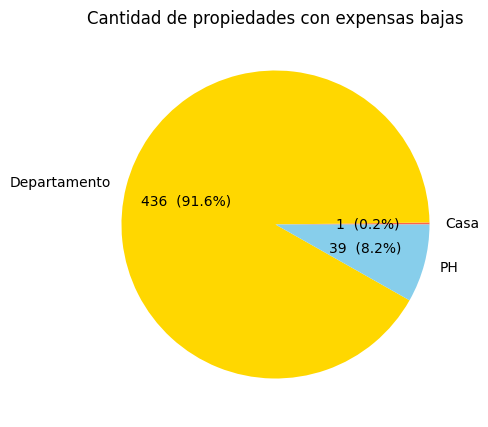

In [80]:
def label_para_chart(val):
    return f'{val / 100 * len(ds_expensas_bajas):.0f}  ({val:.1f}%)'

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.set_title('Cantidad de propiedades con expensas bajas')

ds_expensas_bajas.groupby('property_type').size().plot(kind='pie', autopct=label_para_chart, textprops={'fontsize': 10},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax1)
ax1.set_ylabel('')
plt.show()

Ahora continuamos buscando las propiedades cuyas descripciones dicen "Expensas altas"

In [65]:
ids_filtrados2= buscar_regex("(?i)Expensas altas")
ds_prueba= pd.DataFrame()

In [66]:
ds_prueba['id']= ids_filtrados2

In [67]:
ds_expensas_altas=ds_prueba.merge(ds_pre, on="id", how="left")

In [68]:
ds_expensas_altas.shape

(0, 18)

In [69]:
ds_expensas_altas['expensas']='Altas'

De aqui podemos observar que ninguna propiedad incluyo en su descripcion Expensas altas , seguramente esto se deba a que al intentar vender una propiedad no es conveniente resaltar si las expensas tienen un alto costo. Genrealmente se listan las virtudes o caracteristicas que pueden atraer compradores.

Luego continuamos buscando las propiedades cuyas descripciones dicen "Sin expensas"

In [70]:
ids_filtrados3= buscar_regex("(?i)Sin Expensas")
ds_prueba= pd.DataFrame()

In [71]:
ds_prueba['id']= ids_filtrados3

In [72]:
ds_sin_expensas=ds_prueba.merge(ds_pre, on="id", how="left")

In [73]:
ds_sin_expensas.shape

(2616, 18)

In [74]:
ds_sin_expensas['expensas']='Sin expensas'

In [75]:
ds_sin_expensas.head()

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description,text_token,text_string,text_string_fdist,text_string_lem,is_equal,expensas
0,VUn7sYrDuGzXYQfY9OSMHw==,2021-09-09,-34.627566,-58.411937,Boedo,Departamento,4.0,3.0,100.0,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,ph a estrenar sanchez de loria al 1500 y const...,"[ph, estrenar, sanchez, loria, 1500, constituc...",estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,True,Sin expensas
1,odR0QjYc3xtaYfqNJvbOSQ==,2021-09-09,-34.627566,-58.411937,Boedo,PH,4.0,3.0,100.0,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,ph a estrenar sanchez de loria al 1500 y const...,"[ph, estrenar, sanchez, loria, 1500, constituc...",estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,True,Sin expensas
2,S5ywfmtXL/q0vaZCysZYKw==,2021-09-09,-34.627566,-58.411937,Boedo,Casa,4.0,3.0,100.0,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,ph a estrenar sanchez de loria al 1500 y const...,"[ph, estrenar, sanchez, loria, 1500, constituc...",estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,estrenar sanchez loria 1500 constitucion 100 a...,True,Sin expensas
3,12RuhOrqSyGFsAQUNm8V/w==,2021-09-09,-34.638552,-58.463278,Flores,PH,3.0,2.0,116.0,79.0,149000.0,PH 3 ambientes Sin expensas - Con cochera - Fl...,"ph de tres ambientes con cochera, patio y terr...","[ph, tres, ambientes, cochera, patio, terraza,...",tres ambientes cochera patio terraza expensas ...,tres ambientes cochera patio terraza expensas ...,tres ambientes cochera patio terraza expensas ...,True,Sin expensas
4,32Yi715ZwH+SAbiRVyr1kA==,2021-09-09,-34.595242,-58.428953,Palermo,PH,5.0,3.0,140.0,120.0,220000.0,Departamento - Palermo,ph al contrafrente en 2 plantas con terraza ...,"[ph, contrafrente, 2, plantas, terraza, parril...",contrafrente plantas terraza parrilla patio am...,contrafrente plantas terraza parrilla patio am...,contrafrente plantas terraza parrilla patio am...,True,Sin expensas


Podemos observar que hay un numero considerable de propiedades que no tienen expensas.

Graficamos nuevamente según tipo de propiedad entre las anteriores:

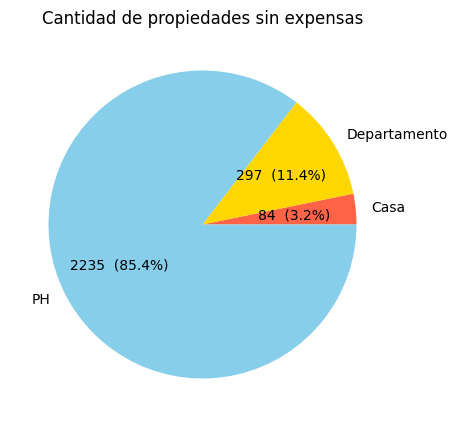

In [79]:
def label_para_chart(val):
    return f'{val / 100 * len(ds_sin_expensas):.0f}  ({val:.1f}%)'

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.set_title('Cantidad de propiedades sin expensas')

ds_sin_expensas.groupby('property_type').size().plot(kind='pie', autopct=label_para_chart, textprops={'fontsize': 10},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax1)
ax1.set_ylabel('')
plt.show()

Como era de esperarse, la mayoria se trata de PH dado que en tales propiedades no se pagan expensas comunmente.

Ahora buscamos aquellas propiedades que aceptan mascotas y las que no

In [81]:
ids_filtrados4= buscar_regex("(?i)Aceptan mascotas")
ds_prueba= pd.DataFrame()

In [82]:
ds_prueba['id']= ids_filtrados4

In [83]:
ds_aceptan_mascotas=ds_prueba.merge(ds_pre, on="id", how="left")

In [84]:
ds_aceptan_mascotas.shape

(111, 18)

In [85]:
ds_aceptan_mascotas.head()

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_description,text_token,text_string,text_string_fdist,text_string_lem,is_equal
0,0+ysKvimIaggpk/HpieO6A==,2021-12-17,-34.563046,-58.450414,Belgrano,Departamento,3.0,2.0,75.0,70.0,240000.0,VENTA DEPTO 3 AMB CON DEPENDENCIA Y COCHERA,corredor responsable: rmx 1 sas - lucas norman...,"[corredor, responsable, rmx, 1, sas, lucas, no...",corredor responsable rmx sas lucas norman cuci...,corredor responsable rmx sas lucas norman cuci...,corredor responsable rmx sas lucas norman cuci...,True
1,xsalo1kpt0Q0hcm8VqqNwg==,2021-01-27,-34.613638,-58.371912,San Telmo,Departamento,1.0,1.0,35.0,28.0,55873.0,Departamento - San Telmo,monoambiente (tipo ph) con patio <br>el depart...,"[monoambiente, tipo, ph, patio, br, departamen...",monoambiente tipo patio departamento cuenta ún...,monoambiente tipo patio departamento cuenta ún...,monoambiente tipo patio departamento cuenta ún...,True
2,4UTWRlfQhwa1ZIVvkMN5IQ==,2021-08-14,-34.639232,-58.499219,Villa Luro,Departamento,2.0,1.0,50.0,46.0,83900.0,DEPARTAMENTO-VENTA- 2 AMBIENTES - VILLA LURO!,corredor responsable: ariel champanier / andre...,"[corredor, responsable, ariel, champanier, and...",corredor responsable ariel champanier andrea b...,corredor responsable ariel champanier andrea b...,corredor responsable ariel champanier andrea b...,True
3,L1NPtKFx7qWJSddYz960uQ==,2021-08-14,-34.621899,-58.398889,San Cristobal,Departamento,1.0,1.0,23.0,23.0,36000.0,OPORTUNIDAD MONOAMBIENTE EN CONSTRUCCIÓN,corredor responsable: martin macagno - cucicba...,"[corredor, responsable, martin, macagno, cucic...",corredor responsable martin macagno cucicba 62...,corredor responsable martin macagno cucicba 62...,corredor responsable martin macagno cucicba 62...,True
4,Gok3x6kl7JtAONcIRnoJ3A==,2021-10-15,-34.610588,-58.473165,Caballito,PH,5.0,3.0,111.0,80.0,100000.0,VENTA HERMOSO PH 5 AMB. EN CABALLITO,corredor responsable: ariel champanier / andre...,"[corredor, responsable, ariel, champanier, and...",corredor responsable ariel champanier andrea b...,corredor responsable ariel champanier andrea b...,corredor responsable ariel champanier andrea b...,True


In [86]:
ids_filtrados5= buscar_regex("(?i)No Aceptan mascotas")
ds_prueba= pd.DataFrame()

In [87]:
ds_prueba['id']= ids_filtrados5

In [88]:
ds_no_aceptan_mascotas=ds_prueba.merge(ds_pre, on="id", how="left")

In [89]:
ds_no_aceptan_mascotas.shape

(3, 18)

Como se observa hay una cantidad bastante pequeña de propiedades que explicitan si permiten mascotas o no.

#### Utilizamos ECmes para detectar posible información importante adicional

In [90]:
#ds_descripciones_sin_id = ds_pre.drop(['id'], axis=1)
ds_descripciones_sin_id = ds_pre['property_description'].copy()

ds_descripciones_sin_id.to_csv('ds_descripciones.txt',header=False)# index=False)

In [91]:
%%capture
!rm -rf ECMes
!git clone https://github.com/juanma1982/ECMes
!sudo apt update
!sudo apt -y install default-jdk
!sudo apt -y install maven

In [92]:
!java --version

openjdk 11.0.16 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Debian-1deb10u1)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Debian-1deb10u1, mixed mode, sharing)


In [93]:
%%bash
rm -rf ECMes/lib
# resolve postagger issue downloading the jar file
mkdir ECMes/lib
cd ECMes/lib
wget -q https://nlp.stanford.edu/software/stanford-postagger-full-2018-10-16.zip
unzip stanford-postagger-full-2018-10-16.zip
cd ..
# change with sed the path of postagger to 3.9.2 downloaded previously
sed -i "s/stanford-postagger-3.9.1.jar/stanford-postagger-full-2018-10-16\/stanford-postagger-3.9.2.jar/g" pom.xml
# fixing jaxb and xml for openjdk11
ex pom.xml <<eof 
/<\/dependencies>/ insert
<dependency>
            <groupId>javax.xml.bind</groupId>
            <artifactId>jaxb-api</artifactId>
            <version>2.3.1</version>
        </dependency>
        <dependency>
            <groupId>org.glassfish.jaxb</groupId>
            <artifactId>jaxb-runtime</artifactId>
            <version>2.3.1</version>
            <scope>runtime</scope>
        </dependency>
.
xit
eof
# compile with mvn jar file
mvn clean compile assembly:single
# copy target jar to root path
mv target/ECMes-1.0-jar-with-dependencies.jar ECMes.jar

Archive:  stanford-postagger-full-2018-10-16.zip
   creating: stanford-postagger-full-2018-10-16/
  inflating: stanford-postagger-full-2018-10-16/README.txt  
  inflating: stanford-postagger-full-2018-10-16/sample-input.txt  
   creating: stanford-postagger-full-2018-10-16/data/
  inflating: stanford-postagger-full-2018-10-16/data/enclitic-inflections.data  
  inflating: stanford-postagger-full-2018-10-16/build.xml  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.sh  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2-javadoc.jar  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-gui.sh  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.jar  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.bat  
  inflating: stanford-postagger-full-2018-10-16/sample-output.txt  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2-sources.jar  
  inflating: stanford-postagger-full-2018-1

Utilizamos la libreria subprocess para poder ejecutar ECmes desde la notebook

In [94]:
import subprocess

In [95]:
result = subprocess.run(['cd ECMes; ./runECMes.sh -f ../ds_descripciones.txt -full -o ../out_ecmes.txt'], shell=True, capture_output=True, text=True)
print(result.stdout)

Analizamos manualmente el resultado contenido en el archivo de salida `out_ecmes.txt`.

Encontramos como dato relevante adicional el hecho de que muchas de las propiedades tienen información acerca de si es o no es accesible para personas con discapcidades fisicas. Esto podria ser de utilidad para generar otra columna. 

Teniendo en cuenta todo lo anterior, se decidió incorporar las siguientes columnas al dataset como ampliación de la información:
- Accequible a personas con discapacidades físicas: Con valores 1 o 0 representando verdadero o falso.
- Mascotas: Con valores 1 o 0 representando si acepta o no acepta.
- Gimnasio: Con valores 1 o 0 representando si tiene o no tiene. 
- Patio: Con valores 1 o 0 representando si tiene o no tiene. 
- Balcon: Con valores 1 o 0 representando si tiene o no tiene. 
- Lavadero: Con valores 1 o 0 representando si tiene o no tiene.
- A estrenar: Con valores 1 o 0 representando si verdadero o falso.
- Expensas: Clasificadas en "Bajas", "Altas", "Sin expensas" y "No aplica" si no se tiene información.


In [96]:
regex_es = re.compile(r'es accesible para personas con discapacidades físicas', re.IGNORECASE)
ds_pre['acceso_personas_discapacidad'] = ds_pre['property_description'].apply(lambda x: 1 if regex_es.search(x) else 0 )


mv: cannot stat 'target/ECMes-1.0-jar-with-dependencies.jar': No such file or directory
Task exception was never retrieved
future: <Task finished name='Task-7' coro=<ScriptMagics.shebang.<locals>._handle_stream() done, defined at /shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/magics/script.py:211> exception=ValueError('Separator is not found, and chunk exceed the limit')>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/asyncio/streams.py", line 540, in readline
    line = await self.readuntil(sep)
  File "/usr/local/lib/python3.9/asyncio/streams.py", line 618, in readuntil
    raise exceptions.LimitOverrunError(
asyncio.exceptions.LimitOverrunError: Separator is not found, and chunk exceed the limit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/magics/script.py", line 213, in _handle_stream
    line = (aw

In [97]:
regex = re.compile(r'Aceptan mascotas|Se aceptan mascotas|Se permiten animales/gi', re.IGNORECASE)

ds_pre['aceptan_mascotas'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)


In [98]:
regex = re.compile(r'gimnasio', re.IGNORECASE)

ds_pre['gimnasio'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)

In [99]:
regex = re.compile(r'patio', re.IGNORECASE)

ds_pre['patio'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)

In [100]:
regex = re.compile(r'balcon', re.IGNORECASE)

ds_pre['balcon'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)

In [101]:
regex = re.compile(r'lavadero', re.IGNORECASE)

ds_pre['lavadero'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)

In [102]:
regex = re.compile(r'a estrenar|nuevo|estrenar', re.IGNORECASE)

ds_pre['a_estrenar'] = ds_pre['property_description'].apply(lambda x: 1 if regex.search(x) else 0)

In [103]:
regexp = re.compile('(?i)Expensas bajas|expensa baja', re.IGNORECASE)
regexl = re.compile(r'sin expensas', re.IGNORECASE)

ds_pre["expensas_bajas"]= ds_pre['property_description'].apply(lambda x:"Bajas" if regexp.search(x) else  "No aplica")
ds_pre["sin_expensas"]= ds_pre['property_description'].apply(lambda x: "Sin" if regexl.search(x) else  "No aplica")

In [104]:
regext = re.compile(r'expensas alta', re.IGNORECASE)

ds_pre["expensas_altas"]= ds_pre['property_description'].apply(lambda x: "Altas" if regext.search(x) else  "No aplica")


In [105]:
ds_pre.head(20)

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,...,acceso_personas_discapacidad,aceptan_mascotas,gimnasio,patio,balcon,lavadero,a_estrenar,expensas_bajas,sin_expensas,expensas_altas
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,...,1,0,0,0,1,1,0,No aplica,No aplica,No aplica
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,...,0,0,0,0,1,1,0,No aplica,No aplica,No aplica
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,...,0,0,0,0,1,1,0,No aplica,No aplica,No aplica
3,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,...,0,0,0,0,0,0,1,No aplica,No aplica,No aplica
4,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,...,0,0,0,1,0,1,1,No aplica,No aplica,No aplica
5,zIXYgKHTdJ5HFYpZ8oROeQ==,2021-09-09,-34.625588,-58.423056,Boedo,PH,4.0,2.0,104.000000,54.0,...,1,0,0,1,0,1,0,No aplica,No aplica,No aplica
6,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,-34.629398,-58.425852,Boedo,Departamento,2.0,1.0,62.000000,44.0,...,1,0,0,1,0,1,0,No aplica,No aplica,No aplica
7,M0g0l0s6S13X+cZlGkUo8g==,2021-09-09,-34.620748,-58.412004,Boedo,Departamento,3.0,2.0,59.000000,55.0,...,1,0,0,0,0,1,0,No aplica,No aplica,No aplica
8,V/KMMLRRx/Nn+g3m5lrW7A==,2021-09-09,-34.626595,-58.420019,Boedo,PH,4.0,3.0,111.000000,101.0,...,1,0,0,0,0,0,0,No aplica,No aplica,No aplica
9,e+HCvsMAePUne1trk2j08A==,2021-09-09,-34.630538,-58.419221,Boedo,Departamento,3.0,2.0,50.000000,50.0,...,0,0,0,0,0,1,0,No aplica,No aplica,No aplica


In [106]:
ds_pre['expensas'] = ""

def check_para_merge_expensas(row):
    if (row['expensas_bajas'] == "No aplica") & (row['expensas_altas'] =="No aplica") & (row['sin_expensas'] =="No aplica"):
        return "No aplica"
    elif (row['expensas_altas'] == "Altas"):
        return "Altas"
    elif (row['expensas_bajas'] == "Bajas"):
        return "Bajas"
    elif (row['sin_expensas'] == "Sin"):
        return "Sin expensas"

ds_pre['expensas'] = ds_pre.apply(check_para_merge_expensas, axis = 1)

ds_pre.head(20)

,id,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,...,aceptan_mascotas,gimnasio,patio,balcon,lavadero,a_estrenar,expensas_bajas,sin_expensas,expensas_altas,expensas
0,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,...,0,0,0,1,1,0,No aplica,No aplica,No aplica,No aplica
1,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,...,0,0,0,1,1,0,No aplica,No aplica,No aplica,No aplica
2,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,...,0,0,0,1,1,0,No aplica,No aplica,No aplica,No aplica
3,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,...,0,0,0,0,0,1,No aplica,No aplica,No aplica,No aplica
4,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,...,0,0,1,0,1,1,No aplica,No aplica,No aplica,No aplica
5,zIXYgKHTdJ5HFYpZ8oROeQ==,2021-09-09,-34.625588,-58.423056,Boedo,PH,4.0,2.0,104.000000,54.0,...,0,0,1,0,1,0,No aplica,No aplica,No aplica,No aplica
6,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,-34.629398,-58.425852,Boedo,Departamento,2.0,1.0,62.000000,44.0,...,0,0,1,0,1,0,No aplica,No aplica,No aplica,No aplica
7,M0g0l0s6S13X+cZlGkUo8g==,2021-09-09,-34.620748,-58.412004,Boedo,Departamento,3.0,2.0,59.000000,55.0,...,0,0,0,0,1,0,No aplica,No aplica,No aplica,No aplica
8,V/KMMLRRx/Nn+g3m5lrW7A==,2021-09-09,-34.626595,-58.420019,Boedo,PH,4.0,3.0,111.000000,101.0,...,0,0,0,0,0,0,No aplica,No aplica,No aplica,No aplica
9,e+HCvsMAePUne1trk2j08A==,2021-09-09,-34.630538,-58.419221,Boedo,Departamento,3.0,2.0,50.000000,50.0,...,0,0,0,0,1,0,No aplica,No aplica,No aplica,No aplica


In [107]:
ds_pre.drop(columns=['expensas_bajas','expensas_altas','sin_expensas'], inplace=True)

### b) Modelos

Ahora que tenemos el dataset ampliado, vamos a realizar el entrenamiento y predicción de precios con el modelo XGBoost.

Para ello vamos a usar dos conjuntos distintos de hiperparametros:
- Los obtenidos en el TP1: `{'subsample': 0.6842105263157894, 'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.20612244897959187, 'lambda': 1, 'gamma': 1, 'alpha': 2}`
- Nuevos hiperparametros a partir de RandomSearchCV aplicado al nuevo dataset expandido.

Previo a esto vamos a realizar toda la ingeniería de features necesaria para el uso del modelo.

Extraemos solo las features que van a ser utilizadas en la regresión:

In [109]:
ds_target_xgb = ds_pre.copy()[[
    'latitud',
    'longitud',
    'property_rooms',
    'property_bedrooms',
    'property_surface_total',
    'property_price',
    'property_surface_covered',
    'property_type',
    'acceso_personas_discapacidad',
    'aceptan_mascotas',
    'gimnasio',
    'patio',
    'balcon',
    'lavadero',
    'a_estrenar',
    'expensas'
    ]]

Convertimos las variable cualitatitas "property_price" y "expensas" en forma numerica por medio de One Hot encoding:

In [111]:
ds_target_xgb = pd.get_dummies(ds_target_xgb,columns=["property_type"],drop_first=True)
ds_target_xgb = pd.get_dummies(ds_target_xgb,columns=["expensas"],drop_first=True)

ds_target_xgb.head(5)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_price,property_surface_covered,acceso_personas_discapacidad,aceptan_mascotas,gimnasio,patio,balcon,lavadero,a_estrenar,property_type_Departamento,property_type_PH,expensas_No aplica,expensas_Sin expensas
0,-34.637319,-58.361124,3.0,2.0,58.000000,82900.0,55.0,1,0,0,0,1,1,0,1,0,1,0
1,-34.628647,-58.361871,4.0,3.0,70.000000,99000.0,70.0,0,0,0,0,1,1,0,1,0,1,0
2,-34.610027,-58.401934,4.0,2.0,124.408727,146000.0,104.0,0,0,0,0,1,1,0,1,0,1,0
3,-34.631621,-58.416825,4.0,2.0,97.673080,250000.0,73.0,0,0,0,0,0,0,1,0,1,1,0
4,-34.623886,-58.412746,2.0,1.0,61.000000,100000.0,46.0,0,0,0,1,0,1,1,0,1,1,0


Separamos los nombres de las features regresoras del target (precio):

In [113]:
features_regresoras = list(ds_target_xgb.columns)
features_regresoras.remove('property_price')
print(features_regresoras)

['latitud', 'longitud', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'acceso_personas_discapacidad', 'aceptan_mascotas', 'gimnasio', 'patio', 'balcon', 'lavadero', 'a_estrenar', 'property_type_Departamento', 'property_type_PH', 'expensas_No aplica', 'expensas_Sin expensas']


Separamos los datos en train y test. Tambien aplicamos un escalado sobre los datos:

In [114]:
#selecciono variables regresoras y a predecir
X = ds_target_xgb[features_regresoras].values
y = ds_target_xgb.property_price

#Separacion Train/test  (80/20)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

#Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### -> XGBoost con hiperparametros previamente obtenidos:

Del TP1 se tenía que los mejores parametros obtenidos por medio de RandomSearchCV eran:

In [115]:
prev_xgb_params = {
                'subsample': 0.6842105263157894,
                'n_estimators': 90,
                'max_depth': 7,
                'learning_rate': 0.20612244897959187,
                'lambda': 1,
                'gamma': 1,
                'alpha': 2
                }

#### Creamos el modelo, entrenamos y predecimos valores

In [116]:
#Creo el modelo y lo entreno
xgb_model = xgboost.XGBRegressor(random_state=23).set_params(**prev_xgb_params)
xgb_model.fit(X_train, y_train)

#Realizamos la predicción
y_pred = xgb_model.predict(X_test)

#### Evaluamos metricas con el modelo evaluado en los datos de test

In [117]:
r2 = round(metrics.r2_score(y_test, y_pred), 4)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.8893
RMSE = 39066.6362


Para ambas métricas se nota una leve mejora de resultados, teniendo en cuenta que para el modelo entrenado con el dataset del TP1 la evaluación sobre los datos de test resultó en las métricas: R2 = 0.8782 ; RMSE = 40987.7925.

El cambio es bastante notable para el score R2, con lo cual vemos que aporta en cierta medida la adquisición de las nuevas features añadidas.


#### Evaluamos metricas sobre los datos de training

In [118]:
y_train_pred = xgb_model.predict(X_train)
r2 = round(metrics.r2_score(y_train, y_train_pred), 4)
rmse = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.9193
RMSE = 33173.9924


Nuevamente se observan mejoras, y aunque sean más relevantes los aumentos sobre los datos de test, no queríamos dejar excluida la mejora en los datos de training. Aumentaron en proporcion muy similar dado que para el TP1 sobre los datos de training se habían obtenido: R2 = 0.9066 ; RMSE = 35696.4882

#### Comparamos los resultados con los del TP1

Si bien se utilizaron los mismos parametros, en los resultados anteriores se observa que la adición de las nuevas columna a partir del análisis del lenguaje natural afectó positivamente en el entrenamiento del modelo para la predicción de los precios. 

Siendo que ambas métricas presentaron una mejora, se esperaría que con otra combinación de hiperparámetros extraidos a partir del nuevo dataset ampliado  se obtengan resultados similares o incluso mejores a los recién mostrados. A continuación vamos a optimizar dichos parametros.

#### -> XGBoost con hiperparametros nuevos:

#### Buscamos hiperparámetros con Random Search Cross Validation

In [165]:
##KFOLD CV Random Search para buscar los mejores hiperparametros

#Cantidad de combinaciones que quiero probar
n=20

#Conjunto de parámetros a usar
params_grid = {
                'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [1,2,3], # 0 1 2
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [0,1,2],
                'n_estimators': list(range(10,161,10)),
                'tree_method': ['approx', 'hist'] # rm
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgb_reg = xgboost.XGBRegressor(random_state=0) 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = xgb_reg,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=23) 

#Busco los hiperparametros que optimizan el R2 Score
randomcv.fit(X_train, y_train);

#Mejor métrica
print(randomcv.best_score_)

0.8941817859677886


Observamos los nuevos parametros encontrados:

In [166]:
params = randomcv.best_params_
print(params)

{'tree_method': 'hist', 'subsample': 0.631578947368421, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.22448979591836737, 'lambda': 2, 'gamma': 2, 'alpha': 2}


#### Creamos el modelo, entrenamos y predecimos valores

In [167]:
#Creo el modelo y lo entreno
xgb_model = xgboost.XGBRegressor(random_state=23).set_params(**params)
xgb_model.fit(X_train, y_train)

#Realizamos la predicción
y_pred = xgb_model.predict(X_test)

#### Evaluamos metricas con el modelo evaluado en los datos de test

In [168]:
r2 = round(metrics.r2_score(y_test, y_pred), 4)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.902
RMSE = 36763.5208


Tal como se esperaba, los resultados fueron aún mejores con la utilización de nuevos parametros optimizados para el dataset ampliado. Se obtuvo una mejora del 0.0127 por sobre el R2 score de los hiperparametros anteriores, y del 0.0238 por sobre el R2 score del dataset del TP1 sin ampliar (todo lo anterior en datos de test).

A su vez se tuvo una disminución importante del error cuadrático medio. 

#### Evaluamos metricas con datos de train

In [169]:
y_train_pred = xgb_model.predict(X_train)
r2 = round(metrics.r2_score(y_train, y_train_pred), 4)
rmse = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.9679
RMSE = 20927.4759


Si bien en este resultado particular se tuvo un aumento mucho mayor a los anteriores, no consideramos que se trate de overfitting dados los resultados mostrados anteriormente sobre el modelo aplicado a los datos de testing, donde se conserva en gran medida la calidad de los resultados de la regresión.

#### Conclusiones de los modelos comparando los datasets

La adición de las features adicionales basadas en la extracción de información del análisis de lenguaje natural mejoraron considerablemente los resultados del entrenamiento del modelo XGBoost y sus predicciones, lo cual tiene sentido para lo que se estaba buscando predecir (el precio) a partir de las columnas añadidas (todas con implicancia lógica sobre el posible aumento de precio que tiene una propiedad en venta). 

#### Exportamos el modelo

Por ultimo almacenamos el modelo entrenado en un archivo:

In [171]:
joblib.dump(xgb_model, 'regresor_xgboost_dataset_ampliado.joblib')

['regresor_xgboost_dataset_ampliado.joblib']

---

## 2. Redes Neuronales

Cargamos los datasets de entrenamiento y testing obtenidos al principio de la sección "3. Clasificación" del TP1.
(Obtenemos los mismos ya divididos dado a cómo se realizó tal partición para preservar los datos de testing como si se desconocieran previo a evaluar modelos).

In [ ]:
# agrego keras y funciones especificas para Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical 

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

In [ ]:
df_target_train = pd.read_csv('df_target_train.csv')
df_target_test  = pd.read_csv('df_target_test.csv')

### Clasificacion

El objectivo es tratar de predecir el atributo `tipo_precio` evaluando metricas tales como precision, recall y F1-score.

In [ ]:
df_target_train = pd.get_dummies(df_target_train, columns=["property_type"],drop_first=True)
df_target_test = pd.get_dummies(df_target_test, columns=["property_type"],drop_first=True)

df_target_train = pd.get_dummies(df_target_train, columns=["tipo_precio"],drop_first=True)
df_target_test = pd.get_dummies(df_target_test, columns=["tipo_precio"],drop_first=True)


Separamos en variables clasificadoras y la que hay que predecir. Escalamos los datos también.

La separacion en train y test venia preparada del TP anterior.

In [ ]:

#seleccionamos variables clasificadoras y a predecir
y_train = df_target_train[['tipo_precio_bajo','tipo_precio_medio']].copy()
y_test = df_target_test[['tipo_precio_bajo','tipo_precio_medio']].copy()

# drop de la variable target del dataset
X_train = df_target_train.drop(['tipo_precio_medio','tipo_precio_bajo'], axis=1)
X_test = df_target_test.drop(['tipo_precio_medio','tipo_precio_bajo'], axis=1)

#Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Viendo la forma del array vemos que tenemos 66284 filas de 8 columnas o features, por lo tanto deberemos crear 8 neuronas de entrada.

In [ ]:
X_train.shape

(66284, 8)

In [ ]:
y_train.head()

,tipo_precio_bajo,tipo_precio_medio
0,1,0
1,0,0
2,0,1
3,0,1
4,1,0


#### Creamos el modelo de regresion

In [ ]:
features = 8                      # Dimension of features
hidden_layer_size = features * 2    # of units in hidden layer
target_size = 2     # number of labels

In [ ]:
## realizamos un random search manual
import random
random.seed(5)

def randomSearchRNCategorical(X, y, features, n, X_test, y_test):
    d_in = features
    activation = ['relu', 'tanh', 'sigmoid', 'softmax']
    nodos =  list(range(2, 20, 2))
    optimizer = ['adam', 'adagrad', 'adamax', 'nadam', 'rmsprop', 'sgd']
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=31)

    best_params = {}
    max_acc = 0

    for i in range(n):

        print(f'iteracion {i}')
        a_1 = random.choice(activation)
        a_2 = random.choice(activation)
        a_3 = random.choice(activation)
        n_1 = random.choice(nodos)
        n_2 = random.choice(nodos)
        opt = random.choice(optimizer)
        ep = 20
        params = {
                'a_1':a_1,
                'a_2':a_2,
                'a_3':a_3,
                'n_1':n_1,
                'n_2':n_2,
                'opt':opt,
                'ep':ep
            }
        print(f'Parametros: {params}')
        model = Sequential()
        model.add(Dense(n_1, activation=a_1, input_shape=(d_in,),  kernel_initializer=initializer))
        model.add(Dense(n_2, activation=a_2,  kernel_initializer=initializer))
        model.add(Dense(2, activation=a_3,  kernel_initializer=initializer))

        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])

        # Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=0)
        # Callback to stop training if no improvement in validation loss for certain number of epochs
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        model.fit(
            X, y,
            epochs=ep,
            validation_data=(X_test, y_test),
            callbacks=[reduce_lr, early_stop],
            verbose=1
        )

        tr_loss, tr_acc = model.evaluate(X, y)
        loss, accuracy = model.evaluate(X_test, y_test)

        # If we got better accuracy in validation, then we save the split scenario and the model
        if accuracy > max_acc:
            max_acc = accuracy
            best_params = params
            print(f'Model changed Accuracy = {accuracy}')

    return (best_params, max_acc)

In [ ]:
( best_params, max_accuracy) = randomSearchRNCategorical(X_train, y_train, features, 50, X_test, y_test)


2072/2072 [==============================] - 4s 2ms/step - loss: 0.4793 - accuracy: 0.4998 - val_loss: 0.4793 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 17/20
2072/2072 [==============================] - 4s 2ms/step - loss: 0.4794 - accuracy: 0.4998 - val_loss: 0.4791 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 18/20
2072/2072 [==============================] - 4s 2ms/step - loss: 0.4793 - accuracy: 0.4998 - val_loss: 0.4792 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 19/20
2072/2072 [==============================] - 4s 2ms/step - loss: 0.4793 - accuracy: 0.4998 - val_loss: 0.4792 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 20/20
518/518 [==============================] - 1s 1ms/step - loss: 0.4793 - accuracy: 0.5013
iteracion 19
Parametros: {'a_1': 'softmax', 'a_2': 'relu', 'a_3': 'tanh', 'n_1': 12, 'n_2': 10, 'opt': 'nadam', 'ep': 20}
Epoch 1/20
/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is

In [ ]:
print( "Mejores params: {}\nMax accuracy: {}\n".format(best_params, max_accuracy))

Mejores params: {'a_1': 'tanh', 'a_2': 'relu', 'a_3': 'tanh', 'n_1': 4, 'n_2': 12, 'opt': 'adagrad', 'ep': 20}
Max accuracy: 0.5490918159484863



In [ ]:
model = Sequential()
model.add(Dense(4, activation='tanh', input_shape=(8,),  kernel_initializer=initializer))
model.add(Dense(12, activation='relu',  kernel_initializer=initializer))
model.add(Dense(2, activation='tanh',  kernel_initializer=initializer))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=0)
# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

model.fit(
    X_train, y_test,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

tr_loss, tr_acc = model.evaluate(X_train, y_train)
loss, accuracy = model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_train)


2072/2072 [==============================] - 5s 2ms/step


In [ ]:
accuracy_score(y_train.to_numpy(), y_pred.round())

0.26665560316215076

#### Entrenamiento

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size=16)


Epoch 1/10
4143/4143 [==============================] - 6s 1ms/step - loss: 0.4749 - accuracy: 0.5000
Epoch 2/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4779 - accuracy: 0.5021
Epoch 3/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4819 - accuracy: 0.5038
Epoch 4/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4843 - accuracy: 0.5025
Epoch 5/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4868 - accuracy: 0.5060
Epoch 6/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4884 - accuracy: 0.5056
Epoch 7/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4907 - accuracy: 0.5050
Epoch 8/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4951 - accuracy: 0.5023
Epoch 9/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.4988 - accuracy: 0.5052
Epoch 10/10
4143/4143 [==============================] - 5s 1ms/step - loss: 0.498

#### Evaluacion

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)


518/518 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.2494


### Regresion

In [ ]:
df_target = pd.read_csv('df_preprocesado.csv')
df_target = df_target.copy()[[
    'latitud',
    'longitud',
    'property_rooms',
    'property_bedrooms',
    'property_surface_total',
    'property_price',
    'property_surface_covered',
    'property_type'
    ]]

df_target = pd.get_dummies(df_target,columns=["property_type"],drop_first=True)
df_target.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_price,property_surface_covered,property_type_Departamento,property_type_PH
0,-34.637319,-58.361124,3.0,2.0,58.000000,82900.0,55.0,1,0
1,-34.628647,-58.361871,4.0,3.0,70.000000,99000.0,70.0,1,0
2,-34.610027,-58.401934,4.0,2.0,124.408727,146000.0,104.0,1,0
3,-34.631621,-58.416825,4.0,2.0,97.673080,250000.0,73.0,0,1
4,-34.623886,-58.412746,2.0,1.0,61.000000,100000.0,46.0,0,1


In [ ]:
#seleccionamos variables regresoras y a predecir
features_regresoras = df_target.columns.tolist()
features_regresoras.remove('property_price')
X = df_target[features_regresoras].values
y = df_target.property_price

#Separacion Train/test  (80/20)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

#Escalamos los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
df_target_train.head()

,property_bedrooms,property_rooms,property_surface_total,property_surface_covered,latitud,longitud,tipo_precio,property_type_Departamento,property_type_PH
0,1.0,1.0,62.313030,32.0,-34.568592,-58.489876,bajo,1,0
1,3.0,4.0,171.842939,159.0,-34.585117,-58.398128,alto,1,0
2,1.0,2.0,53.000000,42.0,-34.597790,-58.431483,medio,1,0
3,1.0,1.0,43.000000,37.0,-34.596583,-58.411316,medio,1,0
4,1.0,1.0,60.588150,30.0,-34.609066,-58.427785,bajo,1,0


#### Scripts para mejorar configuración de parametros

Una especie de random search para identificar parametros y reducir opciones

In [ ]:
## realizamos un random search manual
from sklearn.metrics import mean_absolute_error
import random
random.seed(5)

def randomSearchRedesNeuronales(X, y, features, n):
    d_in = len(features)
    activation = ['relu', 'tanh', 'elu']
    nodos =  list(range(2, 13, 2))
    optimizer = ['adam', 'adagrad', 'adamax', 'nadam', 'rmsprop', 'sgd']
    epoch = list(range(5, 26, 5))
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=31)
    1
    best_params = {}
    min_error = float('inf')

    for i in range(n):

        print(f'iteracion {i}')
        a_1 = random.choice(activation)
        a_2 = random.choice(activation)
        a_3 = random.choice(activation)
        n_1 = andom.choice(nodos)
        n_2 = random.choice(nodos)
        opt = 'sgd' #random.choice(optimizer)
        ep = random.choice(epoch)
        params = {
                'a_1':a_1,
                'a_2':a_2,
                'a_3':a_3,
                'n_1':n_1,
                'n_2':n_2,
                'opt':opt,
                'ep':ep
            }
        print(f'Parametros: {params}')
        model = Sequential()
        model.add(Dense(n_1, activation=a_1, input_shape=(d_in,),  kernel_initializer=initializer))
        model.add(Dense(n_2, activation=a_2,  kernel_initializer=initializer))
        model.add(Dense(1  , activation=a_3,  kernel_initializer=initializer))

        model.compile(loss="mae", optimizer=opt, metrics=['mae'])

        model.fit(X, y, epochs = ep)
        y_pred = model.predict(X)
        error = mean_absolute_error(y, y_pred)
        print(f'error = {error}')

        if error < min_error:
            min_error = error
            best_params = params

    return (best_params, min_error)



In [ ]:
#best_params, error = randomSearchRedesNeuronales(X_train, y_train, features_regresoras, 10)

iteracion 0
Parametros: {'a_1': 'elu', 'a_2': 'elu', 'a_3': 'relu', 'n_1': 8, 'n_2': 4, 'opt': 'sgd', 'ep': 5}
Epoch 1/5
2072/2072 [==============================] - 9s 4ms/step - loss: 87140.2812 - mae: 87140.2812
Epoch 2/5
2072/2072 [==============================] - 8s 4ms/step - loss: 57806.0938 - mae: 57806.0938
Epoch 3/5
2072/2072 [==============================] - 8s 4ms/step - loss: 50359.8438 - mae: 50359.8438
Epoch 4/5
2072/2072 [==============================] - 8s 4ms/step - loss: 47712.5195 - mae: 47712.5195
Epoch 5/5
2072/2072 [==============================] - 6s 3ms/step
error = 45611.365822870146
iteracion 1
Parametros: {'a_1': 'elu', 'a_2': 'sigmoid', 'a_3': 'tanh', 'n_1': 8, 'n_2': 10, 'opt': 'sgd', 'ep': 5}
Epoch 1/5
2072/2072 [==============================] - 9s 4ms/step - loss: 170024.0469 - mae: 170024.0469
Epoch 2/5
2072/2072 [==============================] - 8s 4ms/step - loss: 170023.7188 - mae: 170023.7188
Epoch 3/5
2072/2072 [==============================

In [ ]:
#best_params

{'a_1': 'elu',
 'a_2': 'elu',
 'a_3': 'relu',
 'n_1': 8,
 'n_2': 4,
 'opt': 'sgd',
 'ep': 5}

In [ ]:
#error

45611.365822870146

Una especie de grid search para refinar otros parametros específicos

In [ ]:
def gridSearchActivation():
    activation = ['relu', 'tanh', 'elu']
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=31)
    params = []
    best_mape = 100
    for act1 in activation:
        for act2 in activation:
            for act3 in activation:

                # creando el modelo
                d_in = len(features_regresoras)
                model = Sequential()
                model.add(Dense(6, input_shape=(d_in,), activation=act1))
                model.add(Dense(6, activation=act2))
                model.add(Dense(1, activation=act3))
                model.compile(loss="mae", optimizer='sgd', metrics=['mae'])

                model.fit(X_train, y_train, epochs=5)
                y_pred_train = model.predict(X_train)
                mape = mean_absolute_percentage_error(y_train, y_pred_train)
                if mape < best_mape:
                    best_mape = mape
                    params = [act1, act2, act3]
    print(f'mape = {best_mape}')
    print(f'params = {params}')
    return params, best_mape

def gridSearchOptimizer(lr=0.001):
    optimizer = [
        tf.keras.optimizers.experimental.Adadelta(learning_rate=lr),
        tf.keras.optimizers.experimental.Adagrad(learning_rate=lr),
        tf.keras.optimizers.Adam(learning_rate=lr),
        tf.keras.optimizers.experimental.Adamax(learning_rate=lr),
        tf.keras.optimizers.experimental.Nadam(learning_rate=lr),
        tf.keras.optimizers.experimental.RMSprop(learning_rate=lr),
        tf.keras.optimizers.experimental.SGD(learning_rate=lr)
    ]
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=31)
    params = []
    best_mape = 100
    for opt in optimizer:

        # creando el modelo
        d_in = len(features_regresoras)
        model = Sequential()
        model.add(Dense(6, input_shape=(d_in,), activation='tanh',  kernel_initializer=initializer))
        model.add(Dense(6, activation='elu',  kernel_initializer=initializer))
        model.add(Dense(1, activation='elu',  kernel_initializer=initializer))
        model.compile(loss="mae", optimizer=opt, metrics=['mae'])

        model.fit(X_train, y_train, epochs=5)
        y_pred_train = model.predict(X_train)
        mape = mean_absolute_percentage_error(y_train, y_pred_train)
        if mape < best_mape:
            best_mape = mape
            params = [opt]

    print(f'mape = {best_mape}')
    print(f'params = {params}')
    return params, best_mape

#### Creación de la red

Una vez encontrados parámetros que mejoran los resultados (no podemos asegurar que son los mejores) creamos y entrenamos la red.

In [ ]:
# creando el modelo
SEED = 2
np.random.seed(SEED)
tf.random.set_seed(SEED)
d_in = len(features_regresoras)
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)
model = Sequential()
model.add(Dense(16, input_shape=(d_in,), activation='tanh',  kernel_initializer=initializer))
model.add(Dense(32, activation='elu',  kernel_initializer=initializer))
model.add(Dropout(0.2, seed=SEED))
model.add(Dense(1, activation='elu',  kernel_initializer=initializer))

lr = 0.001
opt = tf.keras.optimizers.experimental.SGD(learning_rate=lr)

model.compile(loss="mae", optimizer=opt, metrics=['mean_absolute_percentage_error'])


# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_lr=1e-8, verbose=0)
# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)



#### Entrenamiento

In [ ]:
# model.fit(X_train, y_train, epochs=10, batch_size=32)
model.fit(
    X_train, y_train,
    epochs=100,
    # validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop]
)
y_pred_train = model.predict(X_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)
print(f'mape = {mape_train}')
print(f'mae = {mae_train}')
print(f'rmse = {rmse_train}')
print(f'r2 = {r2_train}')

Epoch 1/100
2072/2072 [==============================] - 7s 3ms/step - loss: 170023.8281 - mean_absolute_percentage_error: 100.0000 - lr: 0.0010
Epoch 2/100
2072/2072 [==============================] - 6s 3ms/step - loss: 169952.0000 - mean_absolute_percentage_error: 99.9405 - lr: 0.0010
Epoch 3/100
2072/2072 [==============================] - 6s 3ms/step - loss: 83197.0078 - mean_absolute_percentage_error: 45.9622 - lr: 0.0010
Epoch 4/100
2072/2072 [==============================] - 6s 3ms/step - loss: 48407.6992 - mean_absolute_percentage_error: 28.8440 - lr: 0.0010
Epoch 5/100
2072/2072 [==============================] - 6s 3ms/step - loss: 47586.9922 - mean_absolute_percentage_error: 28.5867 - lr: 0.0010
Epoch 6/100
2072/2072 [==============================] - 6s 3ms/step - loss: 46848.0469 - mean_absolute_percentage_error: 28.5552 - lr: 0.0010
Epoch 7/100
2072/2072 [==============================] - 6s 3ms/step - loss: 46580.6445 - mean_absolute_percentage_error: 28.3629 - lr: 0.0

#### Evaluacion

In [ ]:
y_pred_test = model.predict(X_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)
print(f'mape = {mape_test}')
print(f'mae = {mae_test}')
print(f'rmse = {rmse_test}')
print(f'r2 = {r2_test}')

518/518 [==============================] - 1s 2ms/step
mape = 0.2510429822912974
mae = 42096.596867975306
rmse = 66978.09363952505
r2 = 0.6747212652092585


#### Comparacion de métricas de train y test

Text(0, 0.5, 'RMSE')

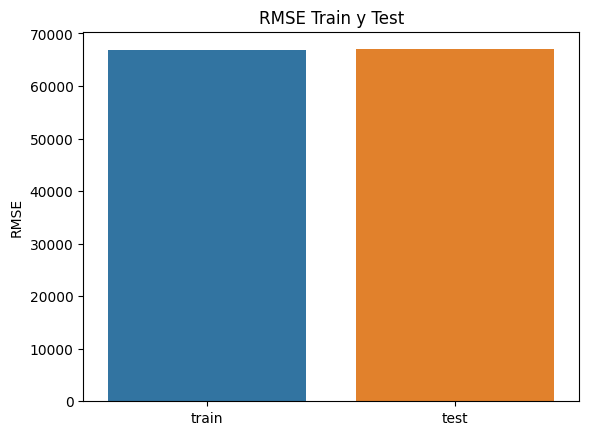

In [ ]:
# RMSE
x = ['train', 'test']
y = [rmse_train, rmse_test]
grf = sns.barplot(x=x, y=y)
grf.set_title('RMSE Train y Test')
grf.set_ylabel('RMSE')

Text(0, 0.5, 'R2')

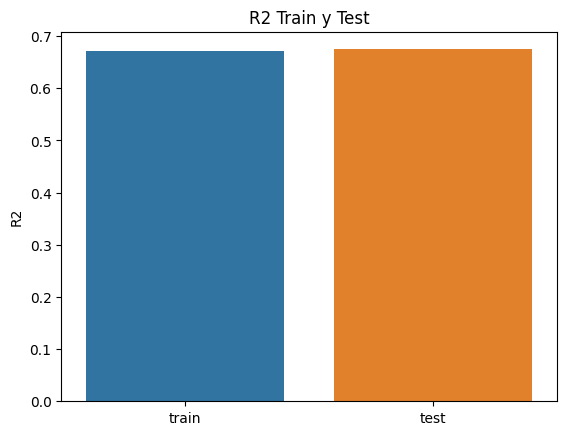

In [ ]:
# R2
x = ['train', 'test']
y = [r2_train, r2_test]
grf = sns.barplot(x=x, y=y)
grf.set_title('R2 Train y Test')
grf.set_ylabel('R2')

#### Comparación de predicciones con valores reales en test

Cuanto más precisas sean las predicciones, mas cerca de la recta estarán los puntos del gráfico

(-28333.450000000004, 839444.45)

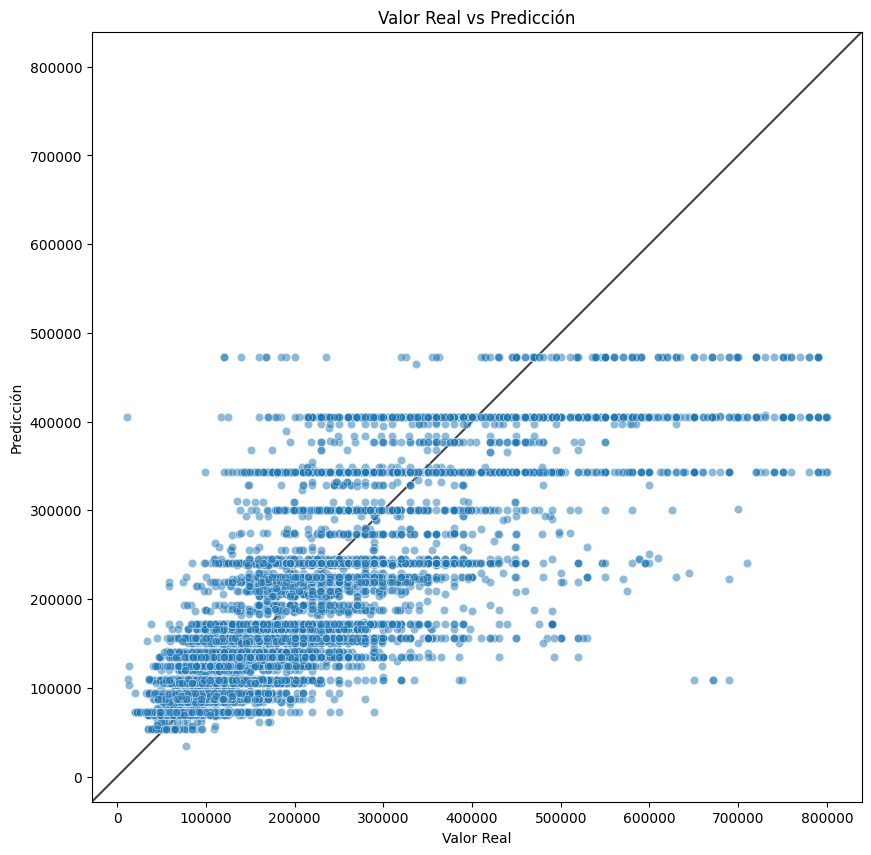

In [ ]:

fig, ax = plt.subplots(figsize=(10,10))
grf = sns.scatterplot(y=np.array([e[0] for e in y_pred_test]), x=y_test, alpha=0.5)
grf.set_title('Valor Real vs Predicción')
grf.set_xlabel('Valor Real')
grf.set_ylabel('Predicción')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### Guardamos el modelo entrenado

In [ ]:
model.save('regresor_redneuronal.h5')

---

## 3. Ensamble de modelos

Funciones para evaluar los modelos y graficar la performance (obtenidos del material de clase).

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y, scorer):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

#Funcion para plotear a performance
def plot_results(model_scores, name, scorer):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title=scorer,
    showlegend=False)
    fig.show()

### Ensamble 1: Voting para clasificación

Cargamos el dataset del TP1 y realizamos un preprocesado similar que el hecho para los modelos de clasificación.

In [ ]:
df_target_train = pd.read_csv('df_target_train.csv')
df_target_test  = pd.read_csv('df_target_test.csv')

In [ ]:
df_target_train = pd.get_dummies(df_target_train, columns=["property_type"],drop_first=True)
df_target_train.head()

,property_bedrooms,property_rooms,property_surface_total,property_surface_covered,latitud,longitud,tipo_precio,property_type_Departamento,property_type_PH
0,1.0,1.0,62.313030,32.0,-34.568592,-58.489876,bajo,1,0
1,3.0,4.0,171.842939,159.0,-34.585117,-58.398128,alto,1,0
2,1.0,2.0,53.000000,42.0,-34.597790,-58.431483,medio,1,0
3,1.0,1.0,43.000000,37.0,-34.596583,-58.411316,medio,1,0
4,1.0,1.0,60.588150,30.0,-34.609066,-58.427785,bajo,1,0


In [ ]:
df_target_test = pd.get_dummies(df_target_test, columns=["property_type"],drop_first=True)
df_target_test.head()

,property_bedrooms,property_rooms,property_surface_total,property_surface_covered,latitud,longitud,tipo_precio,property_type_Departamento,property_type_PH
0,1.0,2.0,33.0,33.0,-34.572279,-58.480608,medio,1,0
1,1.0,2.0,46.0,42.0,-34.574484,-58.480258,medio,1,0
2,1.0,2.0,52.0,43.0,-34.649024,-58.507025,medio,1,0
3,2.0,3.0,52.0,48.0,-34.571143,-58.480552,medio,1,0
4,1.0,1.0,34.0,31.0,-34.604666,-58.396460,medio,1,0


Separamos en variables clasificadoras y la que hay que predecir. Escalamos los datos también.

La separacion en train y test venia preparada del TP anterior.

In [ ]:
#seleccionamos variables clasificadoras y a predecir
y_train = df_target_train['tipo_precio'].copy()
y_test = df_target_test['tipo_precio'].copy()

X_train = df_target_train.drop('tipo_precio', axis=1)
X_test = df_target_test.drop('tipo_precio', axis=1)

#Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Ahora comenzamos el ensamble con los siguientes modelos:

KNN (TP1)
Random Forest (TP1)
Red Neuronal (TP2)

Algunos modelos serán importados del TP1 y el de Redes Neuronales será el entrenado en el Punto 2 de este TP. Como los modelos ya están optimizados y entrenados, los usaremos en el mismo estado que cuando son importados.

In [ ]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
def redClasificadora():
    return keras.models.load_model('clasificador_redneuronal.h5')

rn = KerasClassifier(model=redClasificadora)

# cargamos los modelos del TP1
knn = joblib.load('clasificador_knn.joblib')
rf = joblib.load('clasificador_randomForest.joblib')

# Modelos
modelos = [ 
    ('knn', knn), 
    ('rf', rf),
    ('rn', rn) 
]

# Creamos ensemble de Votación
voting_model = VotingClassifier(estimators = modelos)

Calculamos y graficamos la perfomance del modelo en entrenamiento.

In [ ]:
#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in modelos:
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train, 'accuracy')
    model_scores[name] = scores

#Performance el modelo en entrenamiento
voting_scores = evaluate_model(voting_model, X_train, y_train, 'accuracy')
model_scores['voting'] = voting_scores

#Grafico performance
plot_results(model_scores, 'voting_model_cv', 'accuracy')

Evaluating knn
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
Evaluating rf
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  4.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

Entrenamos el modelo y predecimos.

In [ ]:
voting_model.fit(X_train, y_train)
y_pred_train = voting_model.predict(X_train)
y_pred_test = voting_model.predict(X_test)

#### Evaluamos métricas

In [ ]:
accuracy_test  = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

print(f'Accuracy score en train = {accuracy_train}')
print(f'Accuracy score en test = {accuracy_test}')

Accuracy score en train = 0.9750618550479754
Accuracy score en test = 0.7288636775089011


Comparación de medidas de train y test


Text(0, 0.5, 'Accuracy')

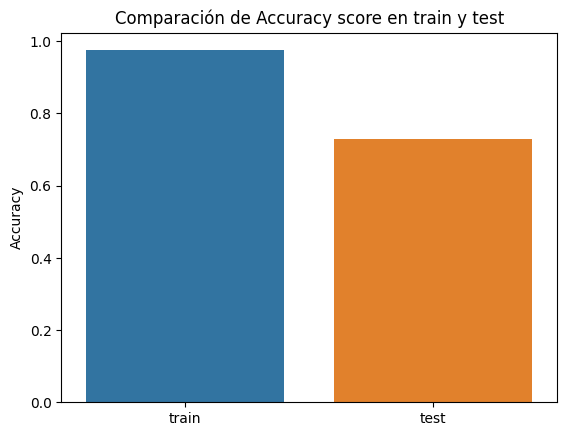

In [ ]:
labels = ['train', 'test']
accuracy = [accuracy_train, accuracy_test]
sns.barplot(x=labels, y=accuracy)
plt.title('Comparación de Accuracy score en train y test')
plt.ylabel('Accuracy')

#### Evaluamos matrices de confusión para train y test

In [ ]:
matriz_train = metrics.confusion_matrix(y_train, y_pred_train)
matriz_test  = metrics.confusion_matrix(y_test, y_pred_test)

Train

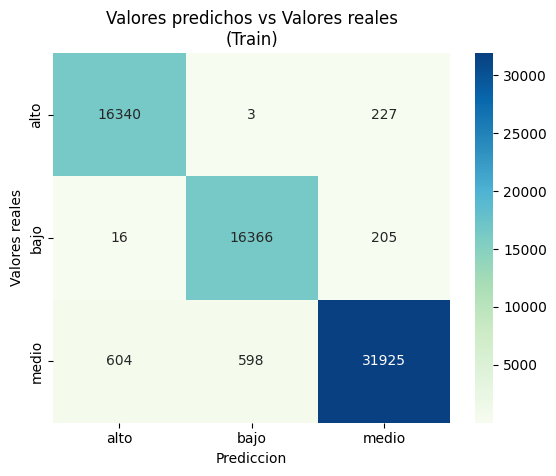

In [ ]:
labels = ['alto','bajo','medio']

#Grafico la matriz de confusión
sns.heatmap(matriz_train,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales\n(Train)')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

Test

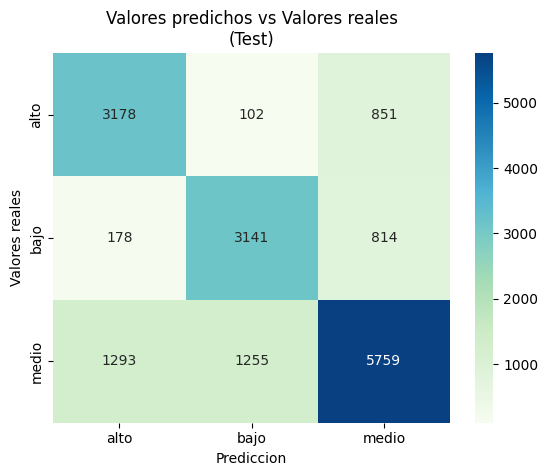

In [ ]:
labels = ['alto','bajo','medio']

#Grafico la matriz de confusión
sns.heatmap(matriz_test,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales\n(Test)')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

### Ensamble 2: Stacking para regresión

Cargamos el dataset del TP1 y realizamos un preprocesado similar que el hecho para los modelos de regresión.

In [ ]:
df_target = pd.read_csv('df_preprocesado.csv')
df_target = df_target.copy()[[
    'latitud',
    'longitud',
    'property_rooms',
    'property_bedrooms',
    'property_surface_total',
    'property_price',
    'property_surface_covered',
    'property_type'
    ]]

df_target = pd.get_dummies(df_target,columns=["property_type"],drop_first=True)
df_target.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_price,property_surface_covered,property_type_Departamento,property_type_PH
0,-34.637319,-58.361124,3.0,2.0,58.000000,82900.0,55.0,1,0
1,-34.628647,-58.361871,4.0,3.0,70.000000,99000.0,70.0,1,0
2,-34.610027,-58.401934,4.0,2.0,124.408727,146000.0,104.0,1,0
3,-34.631621,-58.416825,4.0,2.0,97.673080,250000.0,73.0,0,1
4,-34.623886,-58.412746,2.0,1.0,61.000000,100000.0,46.0,0,1


In [ ]:
features_regresoras = list(df_target.columns)
features_regresoras.remove('property_price')
print(features_regresoras)

['latitud', 'longitud', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_type_Departamento', 'property_type_PH']


Separación en train y test

In [ ]:
#seleccionamos variables regresoras y a predecir
X = df_target[features_regresoras].values
y = df_target.property_price

#Separacion Train/test  (80/20)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

#Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Ahora comenzamos el ensamble con los siguientes modelos:
- XGBoost (TP1)
- KNN (TP1)
- Red Neuronal (TP2)

Algunos modelos serán importados del TP1 y el de Redes Neuronales será el entrenado en el Punto 2 de este TP. Como los modelos ya están optimizados y entrenados, los usaremos en el mismo estado que cuando son importados.

In [ ]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
def redRegresora():
    return keras.models.load_model('regresor_redneuronal.h5')
xgb = xgboost.XGBRegressor()
xgb.load_model('regresor_xgb.json')
knn = joblib.load('regresor_knn.joblib')
rn = KerasRegressor(model=redRegresora)

modelos = [
    ('xgb', xgb),
    ('knn', knn),
    ('rn', rn)
]

# Modelo Stacking
stacking_model = StackingRegressor( estimators=modelos,
                                    passthrough=True, 
                                    cv=5 )

Calculamos y graficamos la perfomance del modelo en entrenamiento.

In [ ]:
#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in modelos:
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train, 'r2')
    model_scores[name] = scores

#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, X_train, y_train, 'r2')
model_scores['stacking'] = stacking_scores

#Grafico performance
plot_results(model_scores, 'stacking_model_cv', 'r2')

Evaluating xgb
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
Evaluating knn
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  6.5min finished


Entrenamos el modelo y predecimos.

In [ ]:
stacking_model.fit(X_train, y_train)
y_pred_train = stacking_model.predict(X_train)
y_pred_test = stacking_model.predict(X_test)

518/518 [==============================] - 1s 2ms/step


#### Evaluamos métricas

In [ ]:
r2_train = round(metrics.r2_score(y_train, y_pred_train), 4)
rmse_train = round(metrics.mean_squared_error(y_train, y_pred_train, squared=False), 4)

print(f'R2 train = {r2_train}')
print(f'RMSE train = {rmse_train}')

r2_test = round(metrics.r2_score(y_test, y_pred_test), 4)
rmse_test = round(metrics.mean_squared_error(y_test, y_pred_test, squared=False), 4)

print(f'R2 test = {r2_test}')
print(f'RMSE test = {rmse_test}')


R2 train = 0.9787
RMSE train = 17043.5351
R2 test = 0.8969
RMSE test = 37717.0494


Comparación de medidas de train y test

In [ ]:
labels = ['train', 'test']
r2 = [r2_train, r2_test]
rmse = [rmse_train, rmse_test]

R2

Text(0, 0.5, 'R2')

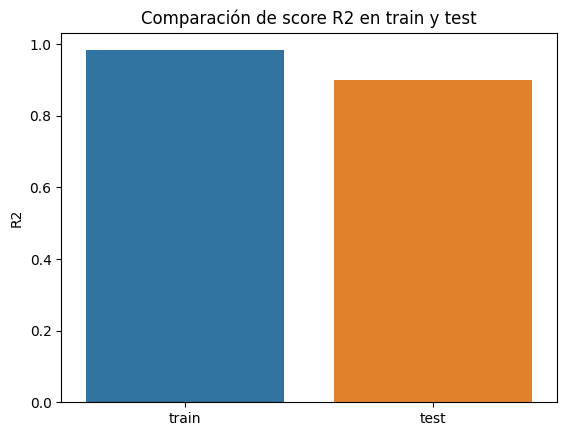

In [ ]:
sns.barplot(x=labels, y=r2)
plt.title('Comparación de score R2 en train y test')
plt.ylabel('R2')

RMSE

Text(0, 0.5, 'RMSE')

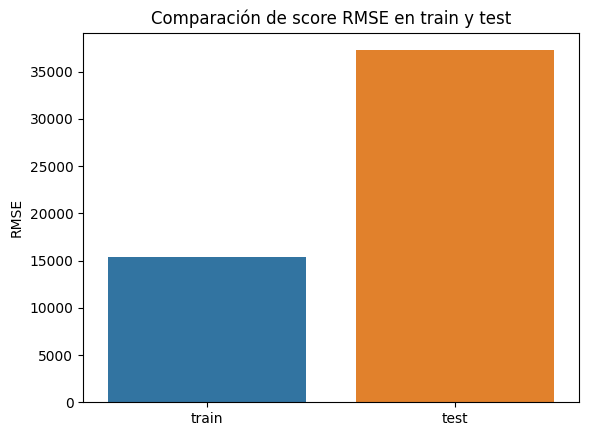

In [ ]:
sns.barplot(x=labels, y=rmse)
plt.title('Comparación de score RMSE en train y test')
plt.ylabel('RMSE')

---

## 4. Conclusiones

...

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf09641a-8f9b-4862-8d2d-9b9f5a372d39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>